# Phase 5: Temporal Pattern Analysis
## Discovering When Customers Buy & How Timing Impacts Value

---

### 📋 Analysis Objectives

**Primary Goals:**
1. **Time-of-Day Insights**: Identify peak activity hours and their correlation with purchase value
2. **Day-of-Week Patterns**: Understand weekend vs. weekday behavior differences
3. **Seasonal Trends**: Decompose temporal patterns using STL to find predictable cycles
4. **Segment-Specific Timing**: Cross-reference temporal patterns with customer segments

**Business Applications:**
- Optimize email campaign send times
- Schedule flash sales for maximum impact
- Allocate customer support resources efficiently
- Predict seasonal inventory needs
- Personalize timing recommendations per segment

---

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Temporal Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

# Visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


---

## 📂 Data Loading

We'll need:
1. **Raw transactional data** (for temporal granularity)
2. **Feature master** (for customer-level aggregations)
3. **Cluster assignments** (RFM + Behavioral clusters)

In [3]:
# Load datasets
path = "/home/cairo/code/portfolio/customer-segmentation/data/raw/"
path_processed = "/home/cairo/code/portfolio/customer-segmentation/data/processed/"
path_reports = "/home/cairo/code/portfolio/customer-segmentation/outputs/reports/"
path_features = "/home/cairo/code/portfolio/customer-segmentation/data/features/"
path_campaigns = "/home/cairo/code/portfolio/customer-segmentation/outputs/campaigns/"
path_figures = "/home/cairo/code/portfolio/customer-segmentation/outputs/figures/"
path_models = "/home/cairo/code/portfolio/customer-segmentation/outputs/models/"


df_raw = pd.read_csv(path + 'online_retail.csv')
df_features = pd.read_csv(path_features + 'features_master.csv')
df_rfm_clusters = pd.read_csv(path_features + 'features_with_rfm_clusters.csv')
df_behavioral_clusters = pd.read_csv(path_features + 'features_with_behavioral_clusters.csv')

# Parse dates properly
df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'])

print(f"📊 Raw transactions: {len(df_raw):,} rows")
print(f"👥 Unique customers: {df_raw['Customer ID'].nunique():,}")
print(f"📅 Date range: {df_raw['InvoiceDate'].min()} to {df_raw['InvoiceDate'].max()}")
print(f"\n✅ All datasets loaded successfully")

📊 Raw transactions: 1,067,371 rows
👥 Unique customers: 5,942
📅 Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00

✅ All datasets loaded successfully


---

## Data Preparation for Temporal Analysis

In [4]:
# Extract temporal features from raw data
df_raw['Hour'] = df_raw['InvoiceDate'].dt.hour
df_raw['DayOfWeek'] = df_raw['InvoiceDate'].dt.dayofweek  # Monday=0, Sunday=6
df_raw['DayName'] = df_raw['InvoiceDate'].dt.day_name()
df_raw['IsWeekend'] = df_raw['DayOfWeek'].isin([5, 6]).astype(int)
df_raw['Date'] = df_raw['InvoiceDate'].dt.date
df_raw['Month'] = df_raw['InvoiceDate'].dt.to_period('M')
df_raw['Quarter'] = df_raw['InvoiceDate'].dt.quarter
df_raw['Year'] = df_raw['InvoiceDate'].dt.year

# Calculate transaction value
df_raw['TxnValue'] = df_raw['Quantity'] * df_raw['Price']

# Remove negative transactions (returns) for temporal pattern clarity
df_purchases = df_raw[df_raw['Quantity'] > 0].copy()

print(f"✅ Temporal features extracted")
print(f"📊 Purchase transactions: {len(df_purchases):,} ({len(df_purchases)/len(df_raw)*100:.1f}% of total)")
df_purchases.head(3)

✅ Temporal features extracted
📊 Purchase transactions: 1,044,421 (97.8% of total)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Hour,DayOfWeek,DayName,IsWeekend,Date,Month,Quarter,Year,TxnValue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,7,1,Tuesday,0,2009-12-01,2009-12,4,2009,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,7,1,Tuesday,0,2009-12-01,2009-12,4,2009,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,7,1,Tuesday,0,2009-12-01,2009-12,4,2009,81.0


---

# Layer 1: Time-of-Day Analysis

## Understanding Hourly Purchase Patterns

In [5]:
# Hourly activity summary
hourly_stats = df_purchases.groupby('Hour').agg({
    'Invoice': 'count',
    'TxnValue': ['sum', 'mean', 'median'],
    'Customer ID': 'nunique'
}).round(2)

hourly_stats.columns = ['Num_Transactions', 'Total_Revenue', 'Avg_Txn_Value', 'Median_Txn_Value', 'Unique_Customers']
hourly_stats['Revenue_Pct'] = (hourly_stats['Total_Revenue'] / hourly_stats['Total_Revenue'].sum() * 100).round(2)
hourly_stats = hourly_stats.reset_index()

print("⏰ Hourly Activity Summary:")
print(hourly_stats.to_string(index=False))

⏰ Hourly Activity Summary:
 Hour  Num_Transactions  Total_Revenue  Avg_Txn_Value  Median_Txn_Value  Unique_Customers  Revenue_Pct
    6                 1       4.25e+00           4.25              4.25                 1         0.00
    7              1064       7.62e+04          71.65             29.89                67         0.37
    8             15688       5.33e+05          33.96             17.70               690         2.56
    9             67140       1.80e+06          26.84             14.85              1391         8.66
   10             90877       2.63e+06          28.93             15.00              2028        12.63
   11            118807       2.54e+06          21.38             10.00              2139        12.21
   12            156812       2.87e+06          18.31              9.90              2589        13.79
   13            147516       2.55e+06          17.28              9.90              2570        12.25
   14            139004       2.36e+06        

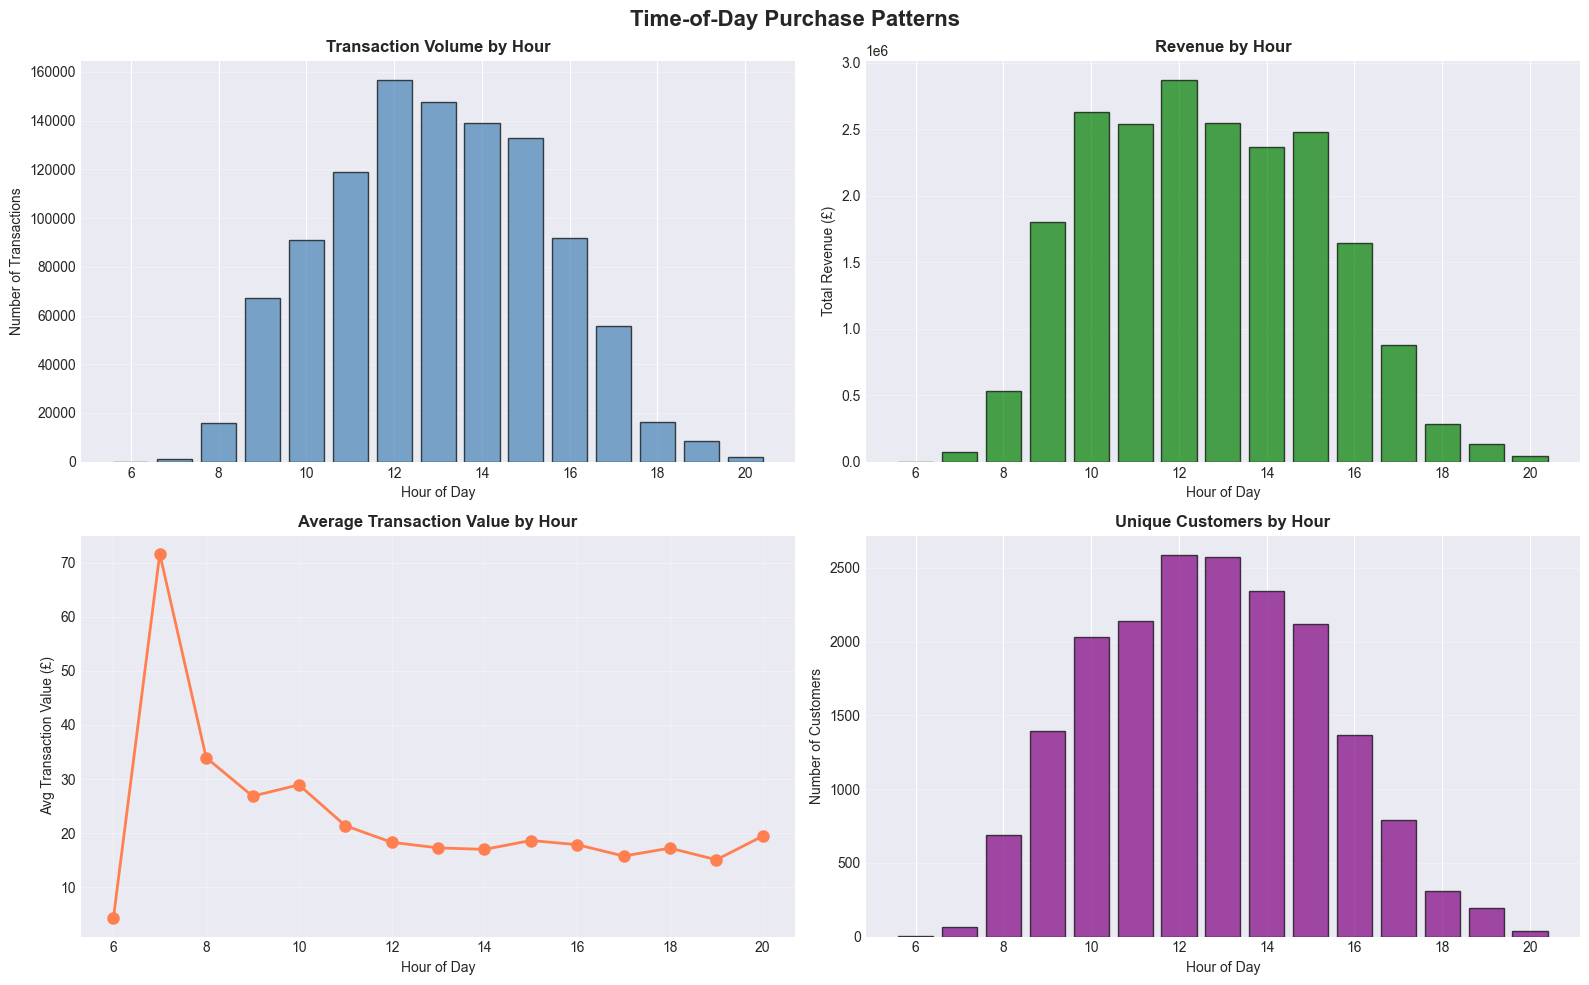


🔍 Key Insights:
   📈 Peak transaction volume: 12:00
   💰 Peak revenue hour: 12:00
   🎯 Highest AOV hour: 7:00


In [7]:
# Visualization: Hourly patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Time-of-Day Purchase Patterns', fontsize=16, fontweight='bold')

# 1. Transaction volume by hour
axes[0, 0].bar(hourly_stats['Hour'], hourly_stats['Num_Transactions'], 
               color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Transaction Volume by Hour', fontweight='bold')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Number of Transactions')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Revenue by hour
axes[0, 1].bar(hourly_stats['Hour'], hourly_stats['Total_Revenue'], 
               color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Revenue by Hour', fontweight='bold')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Total Revenue (£)')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Average transaction value by hour
axes[1, 0].plot(hourly_stats['Hour'], hourly_stats['Avg_Txn_Value'], 
                marker='o', linewidth=2, markersize=8, color='coral')
axes[1, 0].set_title('Average Transaction Value by Hour', fontweight='bold')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Avg Transaction Value (£)')
axes[1, 0].grid(alpha=0.3)

# 4. Unique customers by hour
axes[1, 1].bar(hourly_stats['Hour'], hourly_stats['Unique_Customers'], 
               color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Unique Customers by Hour', fontweight='bold')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Number of Customers')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Peak hours identification
peak_volume_hour = hourly_stats.loc[hourly_stats['Num_Transactions'].idxmax(), 'Hour']
peak_revenue_hour = hourly_stats.loc[hourly_stats['Total_Revenue'].idxmax(), 'Hour']
peak_aov_hour = hourly_stats.loc[hourly_stats['Avg_Txn_Value'].idxmax(), 'Hour']

print(f"\n🔍 Key Insights:")
print(f"   📈 Peak transaction volume: {peak_volume_hour}:00")
print(f"   💰 Peak revenue hour: {peak_revenue_hour}:00")
print(f"   🎯 Highest AOV hour: {peak_aov_hour}:00")

---

# Layer 2: Day-of-Week Analysis

## Weekend vs. Weekday Behavior Patterns

In [8]:
# Day-of-week statistics
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

daily_stats = df_purchases.groupby('DayName').agg({
    'Invoice': 'count',
    'TxnValue': ['sum', 'mean', 'median'],
    'Customer ID': 'nunique'
}).round(2)

daily_stats.columns = ['Num_Transactions', 'Total_Revenue', 'Avg_Txn_Value', 'Median_Txn_Value', 'Unique_Customers']
daily_stats['Revenue_Pct'] = (daily_stats['Total_Revenue'] / daily_stats['Total_Revenue'].sum() * 100).round(2)
daily_stats = daily_stats.reindex(day_order)

print("📅 Day-of-Week Activity Summary:")
print(daily_stats.to_string())

📅 Day-of-Week Activity Summary:
           Num_Transactions  Total_Revenue  Avg_Txn_Value  Median_Txn_Value  Unique_Customers  Revenue_Pct
DayName                                                                                                   
Monday               185461       3.60e+06          19.42              9.35              2549        17.30
Tuesday              191686       4.19e+06          21.84             10.08              2754        20.11
Wednesday            180993       3.56e+06          19.69             10.20              2755        17.12
Thursday             197737       4.25e+06          21.51             10.50              3000        20.43
Friday               149993       3.35e+06          22.37             10.20              2441        16.12
Saturday                400       9.80e+03          24.51             17.70                26         0.05
Sunday               138151       1.85e+06          13.37              7.49              2128         8.87


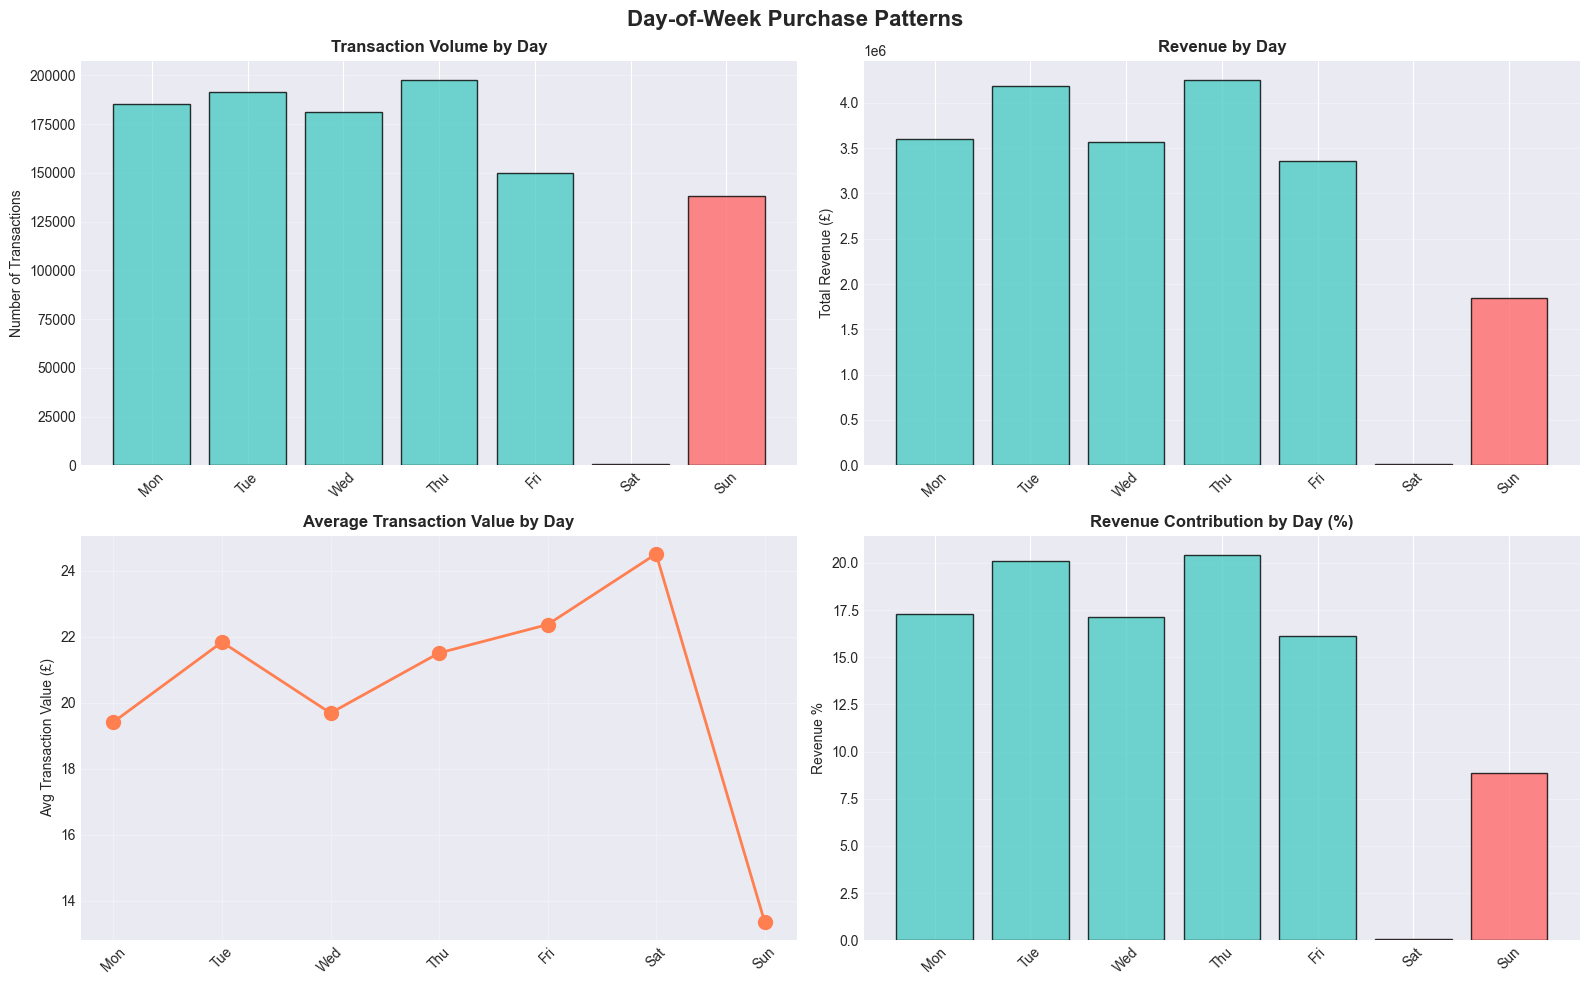

In [9]:
# Visualization: Day-of-week patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Day-of-Week Purchase Patterns', fontsize=16, fontweight='bold')

# 1. Transaction volume by day
axes[0, 0].bar(range(7), daily_stats['Num_Transactions'], 
               color=['#FF6B6B' if day in ['Saturday', 'Sunday'] else '#4ECDC4' for day in day_order],
               alpha=0.8, edgecolor='black')
axes[0, 0].set_xticks(range(7))
axes[0, 0].set_xticklabels([d[:3] for d in day_order], rotation=45)
axes[0, 0].set_title('Transaction Volume by Day', fontweight='bold')
axes[0, 0].set_ylabel('Number of Transactions')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Revenue by day
axes[0, 1].bar(range(7), daily_stats['Total_Revenue'], 
               color=['#FF6B6B' if day in ['Saturday', 'Sunday'] else '#4ECDC4' for day in day_order],
               alpha=0.8, edgecolor='black')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels([d[:3] for d in day_order], rotation=45)
axes[0, 1].set_title('Revenue by Day', fontweight='bold')
axes[0, 1].set_ylabel('Total Revenue (£)')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Average transaction value by day
axes[1, 0].plot(range(7), daily_stats['Avg_Txn_Value'], 
                marker='o', linewidth=2, markersize=10, color='coral')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels([d[:3] for d in day_order], rotation=45)
axes[1, 0].set_title('Average Transaction Value by Day', fontweight='bold')
axes[1, 0].set_ylabel('Avg Transaction Value (£)')
axes[1, 0].grid(alpha=0.3)

# 4. Revenue percentage contribution
axes[1, 1].bar(range(7), daily_stats['Revenue_Pct'], 
               color=['#FF6B6B' if day in ['Saturday', 'Sunday'] else '#4ECDC4' for day in day_order],
               alpha=0.8, edgecolor='black')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels([d[:3] for d in day_order], rotation=45)
axes[1, 1].set_title('Revenue Contribution by Day (%)', fontweight='bold')
axes[1, 1].set_ylabel('Revenue %')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Weekend vs. Weekday comparison
weekend_weekday_stats = df_purchases.groupby('IsWeekend').agg({
    'Invoice': 'count',
    'TxnValue': ['sum', 'mean'],
    'Customer ID': 'nunique'
}).round(2)

weekend_weekday_stats.columns = ['Num_Transactions', 'Total_Revenue', 'Avg_Txn_Value', 'Unique_Customers']
weekend_weekday_stats.index = ['Weekday', 'Weekend']

print("\n📊 Weekend vs. Weekday Comparison:")
print(weekend_weekday_stats)

# Statistical test: Is there a significant difference in AOV?
weekday_aov = df_purchases[df_purchases['IsWeekend'] == 0]['TxnValue']
weekend_aov = df_purchases[df_purchases['IsWeekend'] == 1]['TxnValue']

t_stat, p_value = stats.ttest_ind(weekday_aov, weekend_aov)
print(f"\n📈 Statistical Test (t-test for AOV difference):")
print(f"   t-statistic: {t_stat:.4f}")
print(f"   p-value: {p_value:.4f}")
print(f"   Conclusion: {'Significant difference' if p_value < 0.05 else 'No significant difference'} in AOV between weekday and weekend")


📊 Weekend vs. Weekday Comparison:
         Num_Transactions  Total_Revenue  Avg_Txn_Value  Unique_Customers
Weekday            905870       1.90e+07          20.93              5564
Weekend            138551       1.86e+06          13.40              2137

📈 Statistical Test (t-test for AOV difference):
   t-statistic: 11.9777
   p-value: 0.0000
   Conclusion: Significant difference in AOV between weekday and weekend


---

# Layer 3: Seasonal Trends & Decomposition

## Using STL Decomposition to Identify Patterns

In [11]:
# Aggregate daily revenue for time series
daily_revenue = df_purchases.groupby('Date')['TxnValue'].sum().reset_index()
daily_revenue.columns = ['Date', 'Revenue']
daily_revenue['Date'] = pd.to_datetime(daily_revenue['Date'])
daily_revenue = daily_revenue.set_index('Date').sort_index()

# Fill missing dates with 0 revenue
daily_revenue = daily_revenue.asfreq('D', fill_value=0)

print(f"📅 Daily revenue time series: {len(daily_revenue)} days")
print(f"📊 Date range: {daily_revenue.index.min()} to {daily_revenue.index.max()}")
print(f"💰 Total revenue: £{daily_revenue['Revenue'].sum():,.2f}")

📅 Daily revenue time series: 739 days
📊 Date range: 2009-12-01 00:00:00 to 2011-12-09 00:00:00
💰 Total revenue: £20,814,292.00


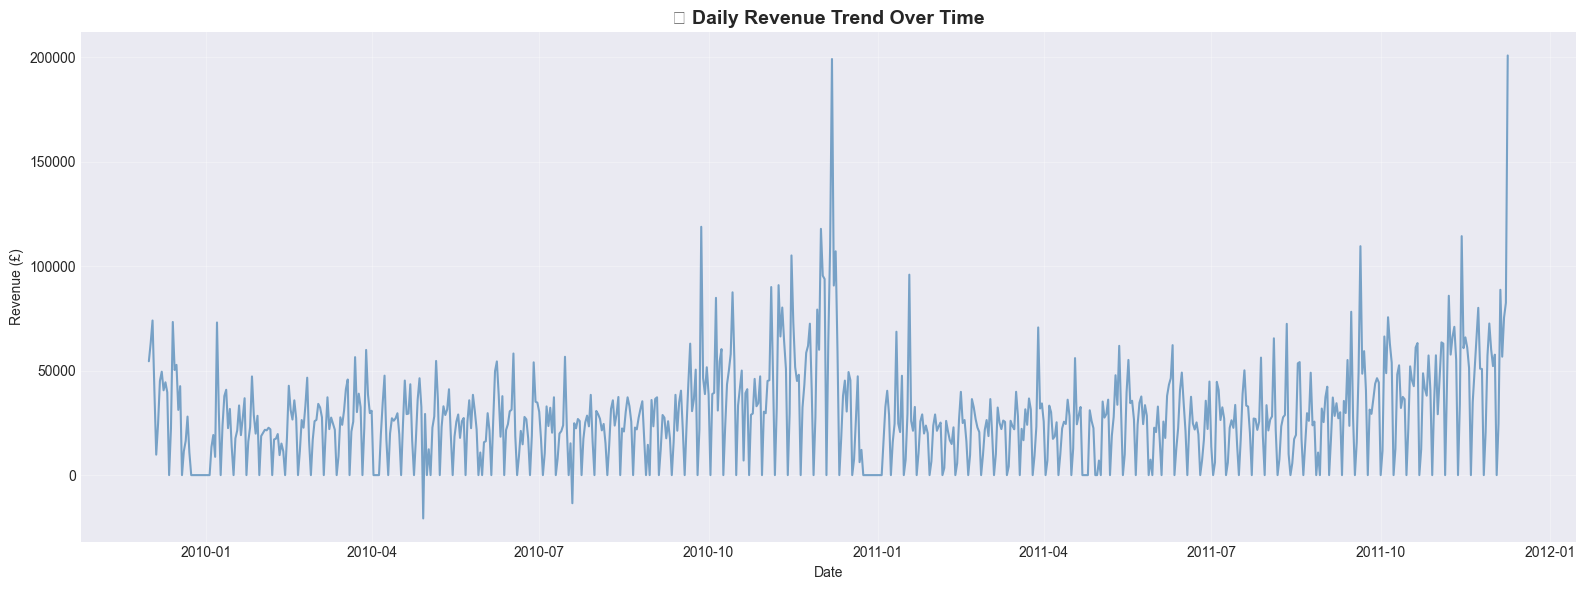

In [12]:
# Plot daily revenue trend
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(daily_revenue.index, daily_revenue['Revenue'], linewidth=1.5, color='steelblue', alpha=0.7)
ax.set_title('📈 Daily Revenue Trend Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue (£)')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

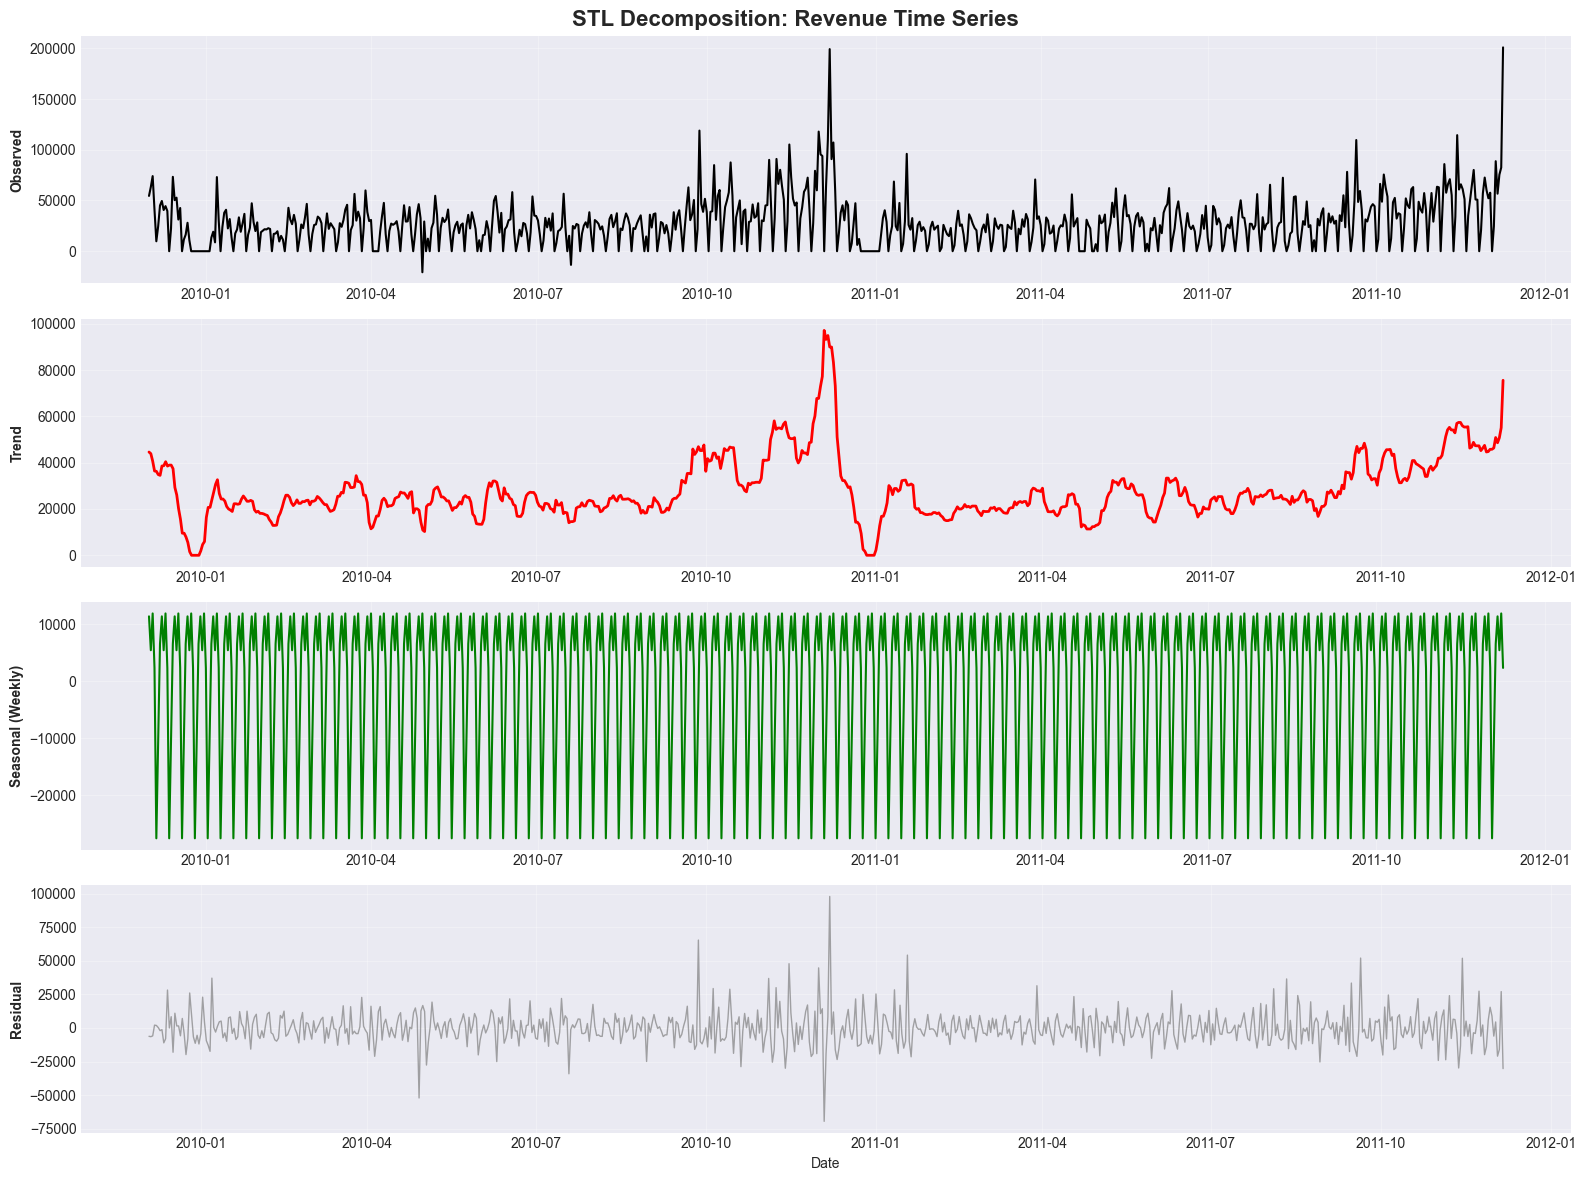

STL Decomposition completed successfully


In [15]:
# STL Decomposition (Seasonal-Trend decomposition using Loess)
# Using weekly seasonality (period=7)
try:
    decomposition = seasonal_decompose(daily_revenue['Revenue'], model='additive', period=7)
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    fig.suptitle('STL Decomposition: Revenue Time Series', fontsize=16, fontweight='bold')
    
    # Original
    axes[0].plot(decomposition.observed, linewidth=1.5, color='black')
    axes[0].set_ylabel('Observed', fontweight='bold')
    axes[0].grid(alpha=0.3)
    
    # Trend
    axes[1].plot(decomposition.trend, linewidth=2, color='red')
    axes[1].set_ylabel('Trend', fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    # Seasonal
    axes[2].plot(decomposition.seasonal, linewidth=1.5, color='green')
    axes[2].set_ylabel('Seasonal (Weekly)', fontweight='bold')
    axes[2].grid(alpha=0.3)
    
    # Residual
    axes[3].plot(decomposition.resid, linewidth=1, color='gray', alpha=0.7)
    axes[3].set_ylabel('Residual', fontweight='bold')
    axes[3].set_xlabel('Date')
    axes[3].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("STL Decomposition completed successfully")
    
except Exception as e:
    print(f"⚠️ STL Decomposition failed: {e}")
    print("   (This may happen with insufficient data or irregular patterns)")

In [16]:
# Monthly and Quarterly trends
monthly_revenue = df_purchases.groupby(df_purchases['InvoiceDate'].dt.to_period('M')).agg({
    'TxnValue': 'sum',
    'Invoice': 'count',
    'Customer ID': 'nunique'
}).reset_index()

monthly_revenue.columns = ['Month', 'Revenue', 'Num_Transactions', 'Unique_Customers']
monthly_revenue['Month'] = monthly_revenue['Month'].astype(str)

print("\n📅 Monthly Revenue Summary:")
print(monthly_revenue.to_string(index=False))


📅 Monthly Revenue Summary:
  Month  Revenue  Num_Transactions  Unique_Customers
2009-12 8.26e+05             44123               955
2010-01 6.53e+05             30741               720
2010-02 5.54e+05             28365               774
2010-03 8.34e+05             40477              1057
2010-04 6.28e+05             33356               942
2010-05 6.60e+05             33971               966
2010-06 7.52e+05             39050              1041
2010-07 6.07e+05             32561               928
2010-08 6.97e+05             32640               911
2010-09 9.24e+05             41186              1145
2010-10 1.13e+06             57939              1497
2010-11 1.47e+06             76596              1607
2010-12 1.26e+06             63813               885
2011-01 6.91e+05             34350               741
2011-02 5.24e+05             27184               758
2011-03 7.18e+05             35915               974
2011-04 5.38e+05             29171               856
2011-05 7.71e+05  


📊 Quarterly Performance:
YearQuarter  Revenue  Num_Transactions  Unique_Customers
    2009-Q4 8.26e+05             44123               955
    2010-Q1 2.04e+06             99583              1805
    2010-Q2 2.04e+06            106377              2047
    2010-Q3 2.23e+06            106387              2060
    2010-Q4 3.86e+06            198348              2670
    2011-Q1 1.93e+06             97449              1776
    2011-Q2 2.07e+06            101519              1991
    2011-Q3 2.51e+06            122605              2161
    2011-Q4 3.30e+06            168030              2561


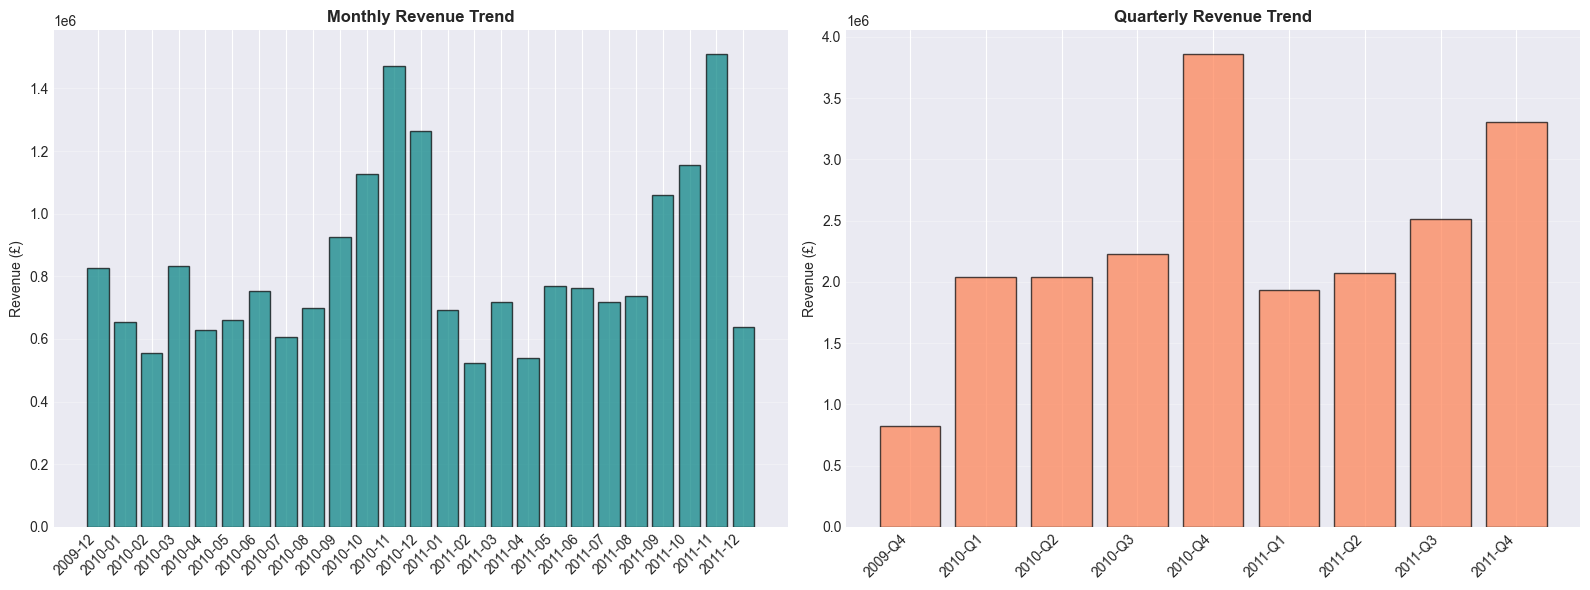

In [18]:
# Quarterly analysis
quarterly_stats = df_purchases.groupby(['Year', 'Quarter']).agg({
    'TxnValue': 'sum',
    'Invoice': 'count',
    'Customer ID': 'nunique'
}).reset_index()

quarterly_stats.columns = ['Year', 'Quarter', 'Revenue', 'Num_Transactions', 'Unique_Customers']
quarterly_stats['YearQuarter'] = quarterly_stats['Year'].astype(str) + '-Q' + quarterly_stats['Quarter'].astype(str)

print("\n📊 Quarterly Performance:")
print(quarterly_stats[['YearQuarter', 'Revenue', 'Num_Transactions', 'Unique_Customers']].to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Monthly revenue
axes[0].bar(range(len(monthly_revenue)), monthly_revenue['Revenue'], 
            color='teal', alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(len(monthly_revenue)))
axes[0].set_xticklabels(monthly_revenue['Month'], rotation=45, ha='right')
axes[0].set_title('Monthly Revenue Trend', fontweight='bold')
axes[0].set_ylabel('Revenue (£)')
axes[0].grid(axis='y', alpha=0.3)

# Quarterly revenue
axes[1].bar(range(len(quarterly_stats)), quarterly_stats['Revenue'], 
            color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(quarterly_stats)))
axes[1].set_xticklabels(quarterly_stats['YearQuarter'], rotation=45, ha='right')
axes[1].set_title('Quarterly Revenue Trend', fontweight='bold')
axes[1].set_ylabel('Revenue (£)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---

# Layer 4: Segment-Specific Temporal Patterns

## Cross-referencing Time Patterns with Customer Segments

In [19]:
# Merge cluster information with purchase data
df_purchases_enriched = df_purchases.merge(
    df_rfm_clusters[['CustomerID', 'Segment', 'RFM_Enhanced_Cluster']],
    left_on='Customer ID',
    right_on='CustomerID',
    how='left'
)

print(f"✅ Enriched {len(df_purchases_enriched):,} transactions with segment information")
print(f"📊 Coverage: {df_purchases_enriched['Segment'].notna().sum() / len(df_purchases_enriched) * 100:.1f}%")

✅ Enriched 1,044,421 transactions with segment information
📊 Coverage: 77.1%


In [20]:
# Hour-of-day by RFM Segment
segment_hourly = df_purchases_enriched.groupby(['Segment', 'Hour']).agg({
    'Invoice': 'count',
    'TxnValue': 'sum'
}).reset_index()

segment_hourly.columns = ['Segment', 'Hour', 'Num_Transactions', 'Total_Revenue']

# Calculate percentage within each segment
segment_totals = segment_hourly.groupby('Segment')['Num_Transactions'].sum()
segment_hourly['Pct_of_Segment'] = segment_hourly.apply(
    lambda row: row['Num_Transactions'] / segment_totals[row['Segment']] * 100, axis=1
)

print("✅ Hourly patterns calculated for each segment")

✅ Hourly patterns calculated for each segment


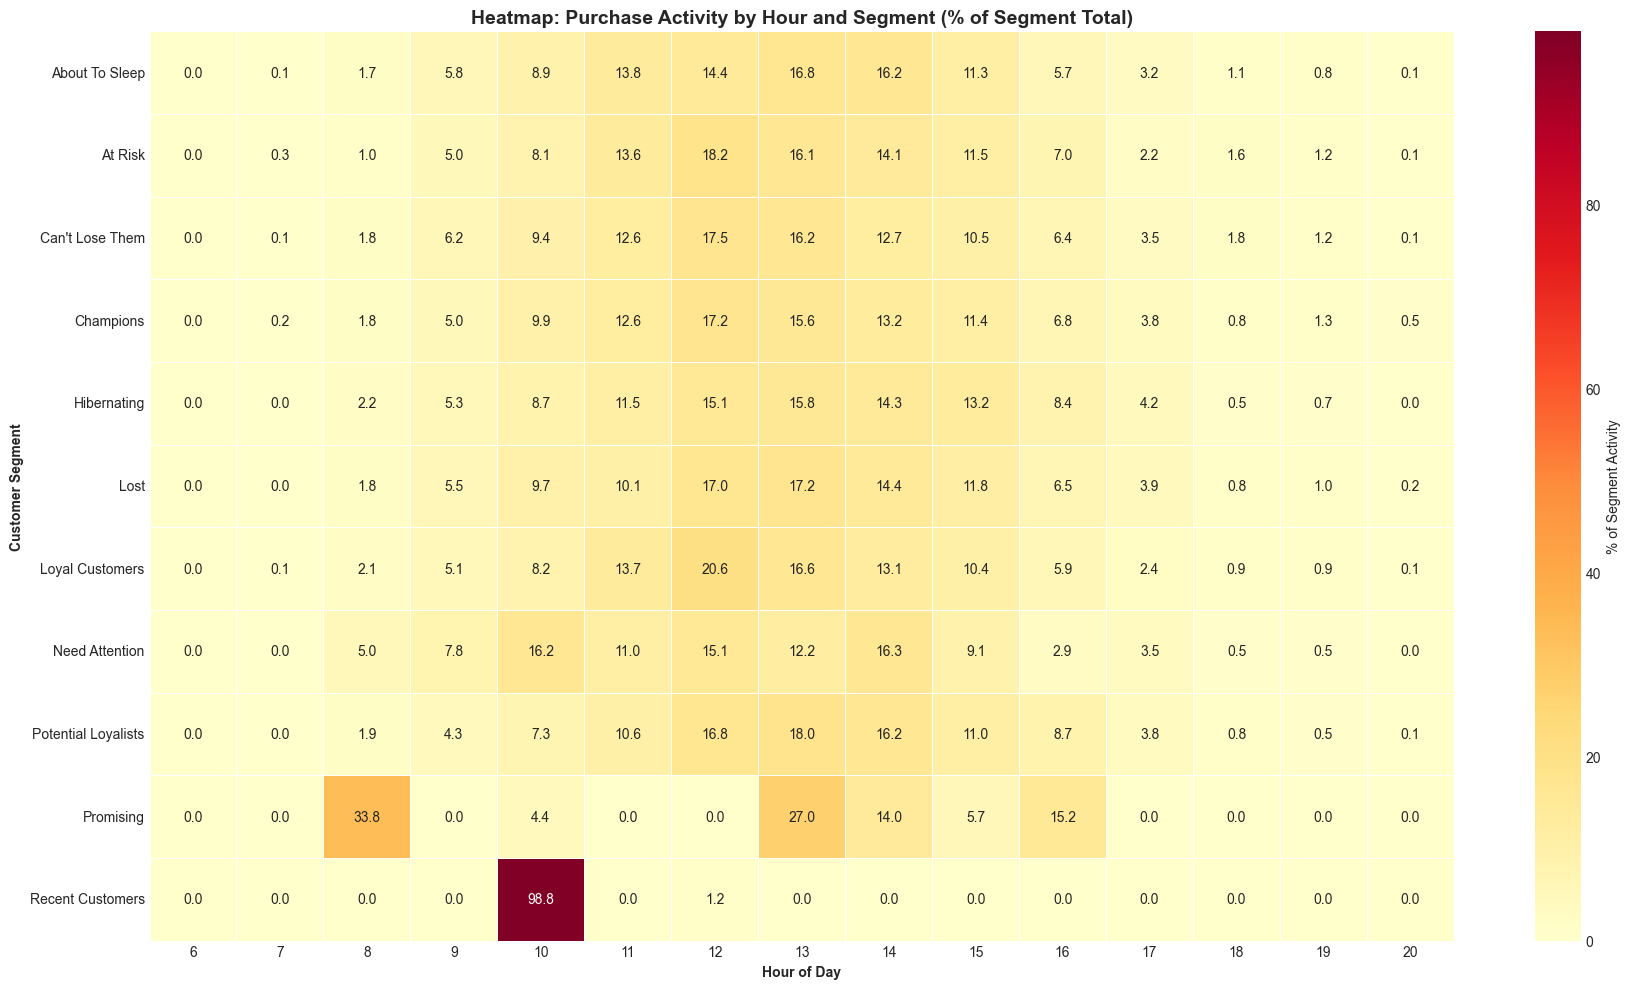

In [21]:
# Heatmap: Hour-of-Day by Segment
pivot_hourly = segment_hourly.pivot(index='Segment', columns='Hour', values='Pct_of_Segment').fillna(0)

plt.figure(figsize=(18, 10))
sns.heatmap(pivot_hourly, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=0.5, cbar_kws={'label': '% of Segment Activity'})
plt.title('Heatmap: Purchase Activity by Hour and Segment (% of Segment Total)', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day', fontweight='bold')
plt.ylabel('Customer Segment', fontweight='bold')
plt.tight_layout()
plt.show()

In [22]:
# Day-of-Week by Segment
segment_daily = df_purchases_enriched.groupby(['Segment', 'DayName']).agg({
    'Invoice': 'count',
    'TxnValue': ['sum', 'mean']
}).reset_index()

segment_daily.columns = ['Segment', 'DayName', 'Num_Transactions', 'Total_Revenue', 'Avg_Txn_Value']

# Calculate percentage within each segment
segment_daily_totals = segment_daily.groupby('Segment')['Num_Transactions'].sum()
segment_daily['Pct_of_Segment'] = segment_daily.apply(
    lambda row: row['Num_Transactions'] / segment_daily_totals[row['Segment']] * 100, axis=1
)

# Reorder days
segment_daily['DayName'] = pd.Categorical(segment_daily['DayName'], categories=day_order, ordered=True)
segment_daily = segment_daily.sort_values(['Segment', 'DayName'])

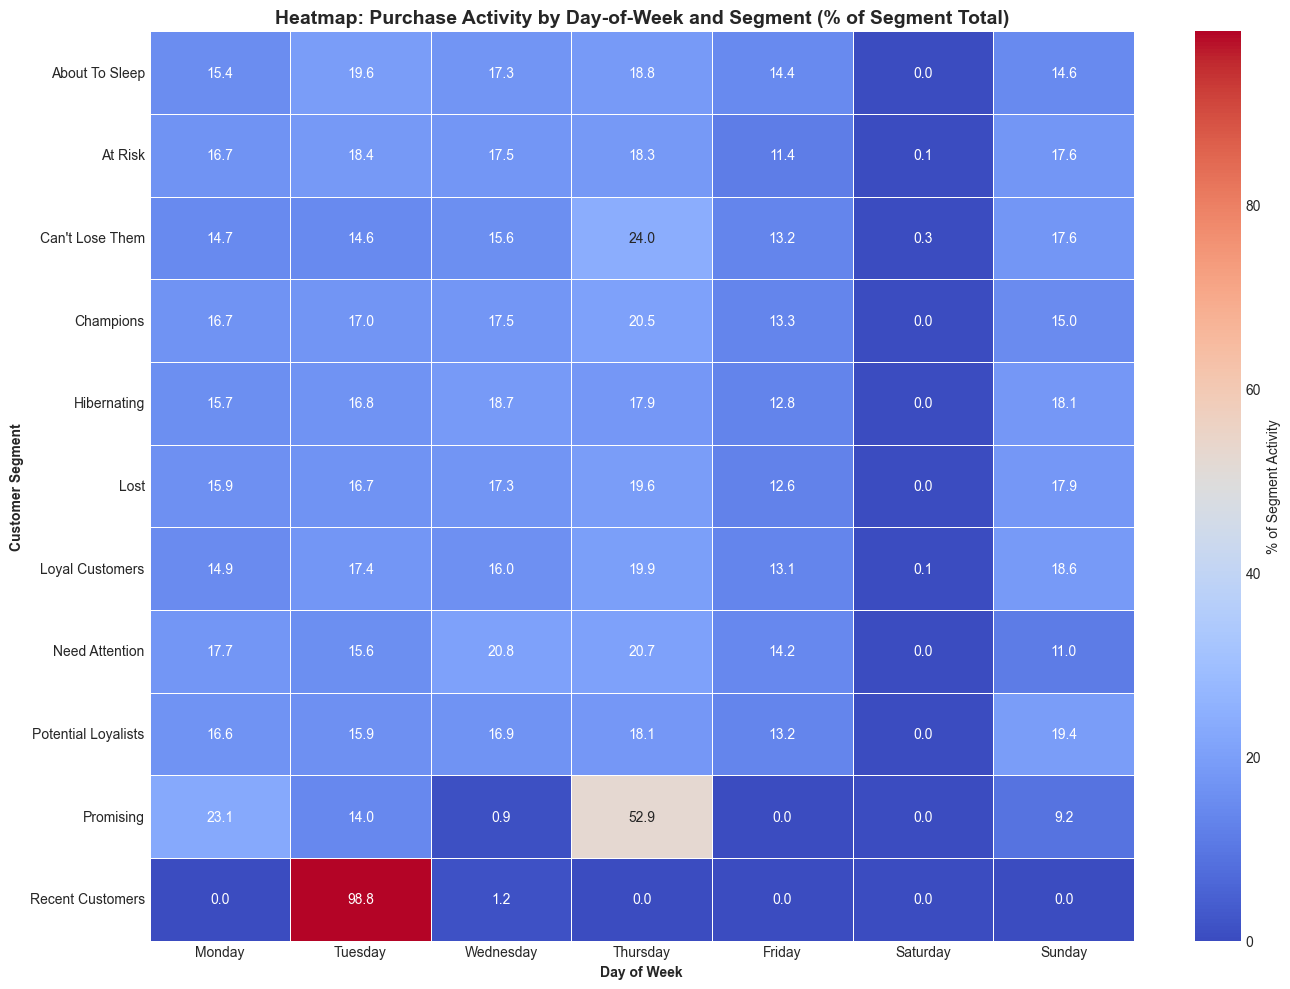

In [23]:
# Heatmap: Day-of-Week by Segment
pivot_daily = segment_daily.pivot(index='Segment', columns='DayName', values='Pct_of_Segment').fillna(0)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_daily, annot=True, fmt='.1f', cmap='coolwarm', linewidths=0.5, cbar_kws={'label': '% of Segment Activity'})
plt.title('Heatmap: Purchase Activity by Day-of-Week and Segment (% of Segment Total)', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week', fontweight='bold')
plt.ylabel('Customer Segment', fontweight='bold')
plt.tight_layout()
plt.show()


🔍 Weekend Shopping Propensity by Segment:
                     Weekend_Ratio
Segment                           
Potential Loyalists          19.35
Loyal Customers              18.69
Hibernating                  18.08
Lost                         17.95
Can't Lose Them              17.94
At Risk                      17.75
Champions                    15.07
About To Sleep               14.61
Need Attention               11.01
Promising                     9.16
Recent Customers              0.00


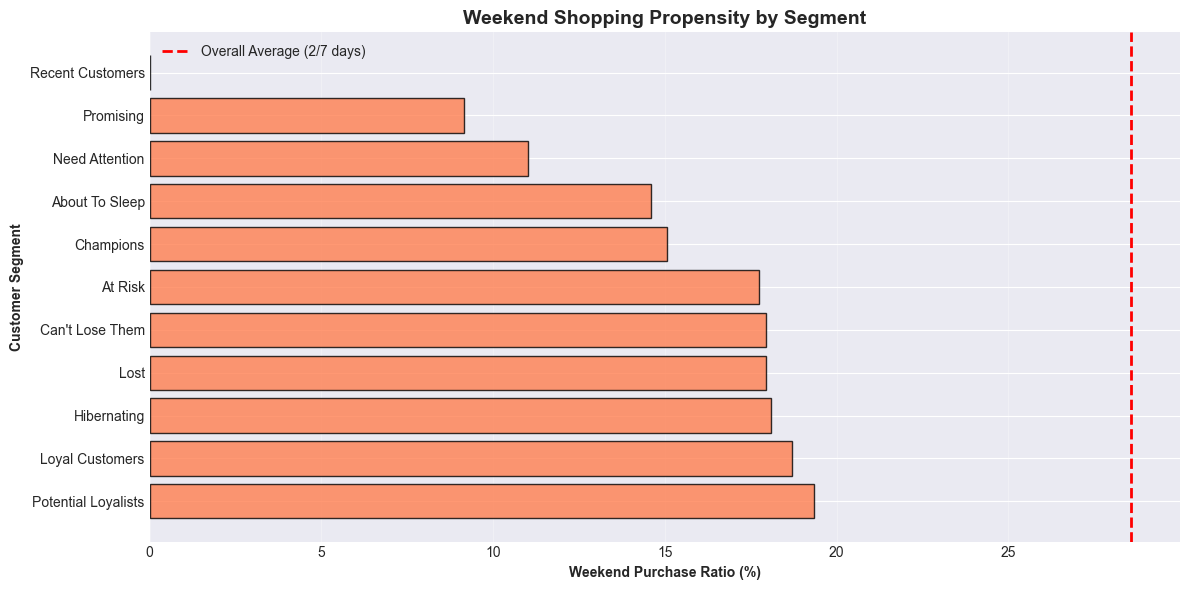

In [24]:
# Weekend ratio by segment
segment_weekend = df_purchases_enriched.groupby(['Segment', 'IsWeekend']).agg({
    'Invoice': 'count'
}).reset_index()

segment_weekend.columns = ['Segment', 'IsWeekend', 'Num_Transactions']
segment_weekend_pivot = segment_weekend.pivot(index='Segment', columns='IsWeekend', values='Num_Transactions').fillna(0)
segment_weekend_pivot.columns = ['Weekday', 'Weekend']
segment_weekend_pivot['Weekend_Ratio'] = (segment_weekend_pivot['Weekend'] / 
                                          (segment_weekend_pivot['Weekday'] + segment_weekend_pivot['Weekend']) * 100).round(2)

segment_weekend_pivot = segment_weekend_pivot.sort_values('Weekend_Ratio', ascending=False)

print("\n🔍 Weekend Shopping Propensity by Segment:")
print(segment_weekend_pivot[['Weekend_Ratio']].to_string())

# Visualization
plt.figure(figsize=(12, 6))
plt.barh(segment_weekend_pivot.index, segment_weekend_pivot['Weekend_Ratio'], color='coral', alpha=0.8, edgecolor='black')
plt.xlabel('Weekend Purchase Ratio (%)', fontweight='bold')
plt.ylabel('Customer Segment', fontweight='bold')
plt.title('Weekend Shopping Propensity by Segment', fontsize=14, fontweight='bold')
plt.axvline(x=28.57, color='red', linestyle='--', linewidth=2, label='Overall Average (2/7 days)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

---

# Creating Behavioral Timing Personas

In [25]:
# Define timing personas based on patterns
# Using customer-level aggregations from features

df_timing = df_features[['CustomerID', 'preferred_hour', 'weekend_ratio', 'is_weekend_shopper']].copy()

# Merge with segments
df_timing = df_timing.merge(
    df_rfm_clusters[['CustomerID', 'Segment', 'RFM_Enhanced_Cluster']],
    on='CustomerID',
    how='left'
)

# Create timing personas
def assign_timing_persona(row):
    hour = row['preferred_hour']
    is_weekend = row['is_weekend_shopper']
    
    if is_weekend == 1:
        return 'Weekend Browser'
    elif hour >= 9 and hour <= 17:
        return 'Weekday Professional'
    elif hour >= 20 or hour <= 6:
        return 'Night Owl'
    else:
        return 'Morning Bird'

df_timing['Timing_Persona'] = df_timing.apply(assign_timing_persona, axis=1)

# Count personas
persona_counts = df_timing['Timing_Persona'].value_counts()
print("\n🎭 Timing Persona Distribution:")
print(persona_counts)
print(f"\nTotal customers classified: {persona_counts.sum():,}")


🎭 Timing Persona Distribution:
Timing_Persona
Weekday Professional    5015
Weekend Browser          652
Morning Bird             204
Night Owl                  7
Name: count, dtype: int64

Total customers classified: 5,878


In [26]:
# Cross-tab: Timing Persona × RFM Segment
persona_segment_crosstab = pd.crosstab(
    df_timing['Timing_Persona'], 
    df_timing['Segment'], 
    margins=True,
    normalize='columns'
) * 100

print("\n📊 Timing Persona Distribution within Each RFM Segment (%):")
print(persona_segment_crosstab.round(1).to_string())


📊 Timing Persona Distribution within Each RFM Segment (%):
Segment               About To Sleep  At Risk  Can't Lose Them  Champions  Hibernating  Lost  Loyal Customers  Need Attention  Potential Loyalists  Promising  Recent Customers   All
Timing_Persona                                                                                                                                                                       
Morning Bird                     3.8      3.8              3.5        1.1          4.2   2.8              2.1             7.7                  4.5       22.2               0.0   3.5
Night Owl                        0.2      0.2              0.0        0.2          0.1   0.0              0.1             0.0                  0.2        0.0               0.0   0.1
Weekday Professional            85.1     82.5             85.9       94.1         81.2  89.1             87.8            88.5                 81.7       55.6             100.0  85.3
Weekend Browser               

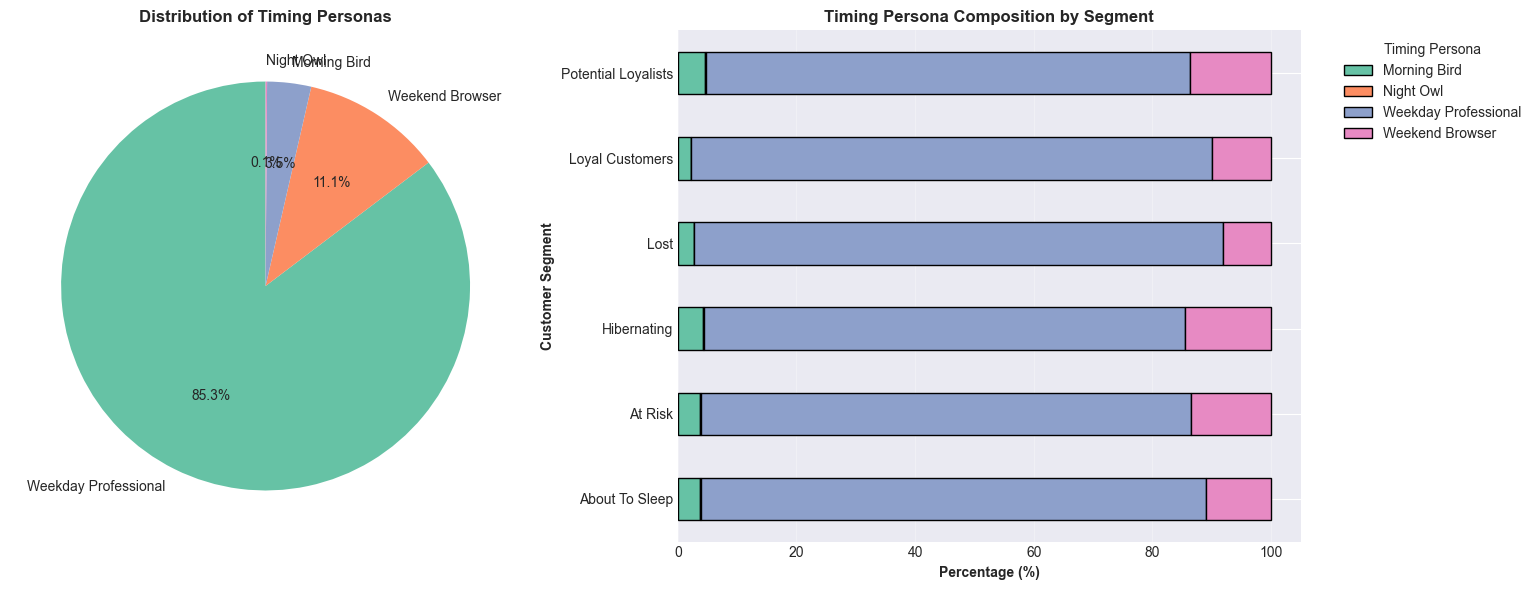

In [27]:
# Visualization: Timing Persona distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart of personas
axes[0].pie(persona_counts, labels=persona_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette('Set2', len(persona_counts)))
axes[0].set_title('Distribution of Timing Personas', fontweight='bold')

# Stacked bar: Persona × Top Segments
top_segments = df_timing['Segment'].value_counts().head(6).index
persona_segment_filtered = pd.crosstab(
    df_timing[df_timing['Segment'].isin(top_segments)]['Segment'],
    df_timing[df_timing['Segment'].isin(top_segments)]['Timing_Persona'],
    normalize='index'
) * 100

persona_segment_filtered.plot(kind='barh', stacked=True, ax=axes[1], 
                              color=sns.color_palette('Set2', 4), edgecolor='black')
axes[1].set_xlabel('Percentage (%)', fontweight='bold')
axes[1].set_ylabel('Customer Segment', fontweight='bold')
axes[1].set_title('Timing Persona Composition by Segment', fontweight='bold')
axes[1].legend(title='Timing Persona', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

---

# 📋 Executive Summary: Temporal Insights

## Key Findings & Business Recommendations

In [28]:
# Compile key metrics for executive summary
exec_summary = {
    "Time-of-Day Insights": {
        "Peak Transaction Hour": f"{peak_volume_hour}:00",
        "Peak Revenue Hour": f"{peak_revenue_hour}:00",
        "Highest AOV Hour": f"{peak_aov_hour}:00",
    },
    "Day-of-Week Insights": {
        "Busiest Day": daily_stats['Num_Transactions'].idxmax(),
        "Highest Revenue Day": daily_stats['Total_Revenue'].idxmax(),
        "Weekend Activity %": f"{weekend_weekday_stats.loc['Weekend', 'Num_Transactions'] / weekend_weekday_stats['Num_Transactions'].sum() * 100:.1f}%",
    },
    "Timing Personas": {
        "Weekend Browsers": f"{persona_counts.get('Weekend Browser', 0):,} customers",
        "Weekday Professionals": f"{persona_counts.get('Weekday Professional', 0):,} customers",
        "Night Owls": f"{persona_counts.get('Night Owl', 0):,} customers",
        "Morning Birds": f"{persona_counts.get('Morning Bird', 0):,} customers",
    }
}

print("\n" + "="*80)
print("📊 TEMPORAL PATTERN ANALYSIS: EXECUTIVE SUMMARY")
print("="*80 + "\n")

for category, metrics in exec_summary.items():
    print(f"\n🔍 {category}:")
    for metric, value in metrics.items():
        print(f"   • {metric}: {value}")

print("\n" + "="*80)
print("💡 BUSINESS RECOMMENDATIONS")
print("="*80 + "\n")

recommendations = [
    f"1. EMAIL CAMPAIGNS: Schedule sends around {peak_volume_hour}:00 for maximum engagement",
    f"2. FLASH SALES: Target {peak_aov_hour}:00 when customers show highest spending propensity",
    "3. CUSTOMER SUPPORT: Allocate resources based on hourly activity patterns",
    "4. SEGMENT-SPECIFIC TIMING: Use timing personas to personalize campaign delivery",
    "5. SEASONAL PLANNING: Monitor quarterly trends for inventory and staffing decisions",
]

for rec in recommendations:
    print(f"   {rec}")

print("\n" + "="*80 + "\n")


📊 TEMPORAL PATTERN ANALYSIS: EXECUTIVE SUMMARY


🔍 Time-of-Day Insights:
   • Peak Transaction Hour: 12:00
   • Peak Revenue Hour: 12:00
   • Highest AOV Hour: 7:00

🔍 Day-of-Week Insights:
   • Busiest Day: Thursday
   • Highest Revenue Day: Thursday
   • Weekend Activity %: 13.3%

🔍 Timing Personas:
   • Weekend Browsers: 652 customers
   • Weekday Professionals: 5,015 customers
   • Night Owls: 7 customers
   • Morning Birds: 204 customers

💡 BUSINESS RECOMMENDATIONS

   1. EMAIL CAMPAIGNS: Schedule sends around 12:00 for maximum engagement
   2. FLASH SALES: Target 7:00 when customers show highest spending propensity
   3. CUSTOMER SUPPORT: Allocate resources based on hourly activity patterns
   4. SEGMENT-SPECIFIC TIMING: Use timing personas to personalize campaign delivery
   5. SEASONAL PLANNING: Monitor quarterly trends for inventory and staffing decisions




---

# Export Results

In [29]:
# Save timing persona assignments
df_timing.to_csv(path_reports + 'customer_timing_personas.csv', index=False)
print("✅ Exported: customer_timing_personas.csv")

# Save hourly statistics
hourly_stats.to_csv(path_reports + 'hourly_purchase_patterns.csv', index=False)
print("✅ Exported: hourly_purchase_patterns.csv")

# Save daily statistics
daily_stats.to_csv(path_reports + 'daily_purchase_patterns.csv')
print("✅ Exported: daily_purchase_patterns.csv")

# Save segment-specific hourly patterns
segment_hourly.to_csv(path_reports + 'segment_hourly_patterns.csv', index=False)
print("✅ Exported: segment_hourly_patterns.csv")

# Save segment-specific daily patterns
segment_daily.to_csv(path_campaigns + 'segment_daily_patterns.csv', index=False)
print("✅ Exported: segment_daily_patterns.csv")

✅ Exported: customer_timing_personas.csv
✅ Exported: hourly_purchase_patterns.csv
✅ Exported: daily_purchase_patterns.csv
✅ Exported: segment_hourly_patterns.csv
✅ Exported: segment_daily_patterns.csv
